<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Weighted_Average_Estimates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Generating Toy Data

We generate toy data according to
$$ Y = f(X) + \epsilon $$

Where $\epsilon$ is mean 0 noise and $f$ is some known function (the "secret mean function").

We will measure how good an estimate $\hat{f}(x)$ is by using the "mean squared error" (or by taking the sqrt, the root-mean-square error):

$$ MSE = \mathbb{E}\left[ \left(Y - \hat{f}(X)\right)^2 \right] $$

By simple algebra we can decompose this as

$$ MSE = Var(\epsilon) + \mathbb{E}\left[ \left(f(X) - \hat{f}(X)\right)^2 \right]$$

In [4]:
#-----------------------------------
#Functions to generate some toy data
#-----------------------------------

# Range of x values possible
x_min,x_max = 0, 90

# "Secret" functions used to generate the data
def secret_mean_func(x):
  return 10.0*np.sin(2*x*(2*np.pi/360))
def secret_sd_func(x):
    return 4.0*np.ones_like(x) #return all 1s but of same shape as x


# Generate random data using np.random
# X are uniform in (x_min,x_max)
# Y generated according to secret mean and sd functions
def generate_data(N):
  def mean_zero_var_one_noise(N):
    return np.random.randn(N)
    #return (np.random.randn(N)**2 - 1)/np.sqrt(2) #Another option

  X = np.random.uniform(x_min,x_max,size=N)
  Epsilon = mean_zero_var_one_noise(N)
  Y = secret_mean_func(X)+secret_sd_func(X)*mean_zero_var_one_noise(N)

  return X,Y

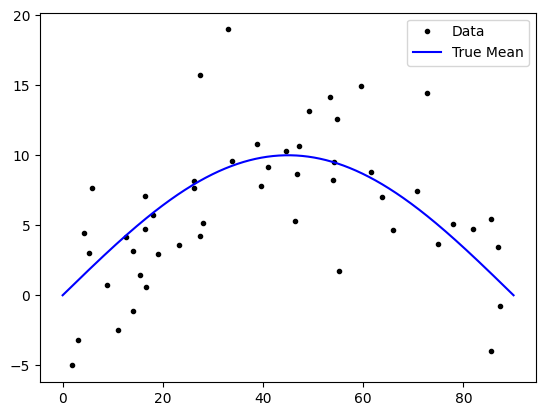

In [5]:
# Plot some toy data!
N = 50
np.random.seed(42)
X,Y = generate_data(N)
plt.plot(X,Y,'k.',label='Data')

# Plot the true mean
x_axis = np.linspace(x_min,x_max,1000)
plt.plot(x_axis,secret_mean_func(x_axis),'b-',label = 'True Mean')
plt.legend()

# Nearby Neightbour Average Estimator

For a given $x$, $\hat{f}(x)$ should average the $y$ values of all the points that are within $\delta$ of $x$. i.e.

$$\hat{f} (x) = \frac{\displaystyle\sum_{i : |x - x_i| < \delta } y_i  } { \# \{i : |x - x_i| < \delta \}  } $$


To implement this, we will use the weighted average over all the training points.

$$\hat{f} (x) = \frac{\displaystyle\sum_{i \in \text{Examples}} y_i \text{Wt}(x,x_i)  } { \displaystyle\sum_{i \in \text{Examples}} \text{Wt}(x,x_i)   } $$


## What should the weight function be?
When the weight function is an indicator function that the two points are within some window size $\delta > 0$ of each other, i.e.

$$ \text{Wt}(x,x^\prime) = \texttt{1}\Big\{ |x - x^\prime| < \delta \Big\} \in \{0,1\}$$

then the weighted average estimator just averages over points within $\delta$ of the point $x$


$$\hat{f}_{\text{NN}}(x) = \frac{\displaystyle\sum_{i : |x - x_i| < \delta } y_i  } { \# \{i : |x - x_i| < \delta \}  } $$

The resulting estimator is very smooth when $\delta$ is large, and gets more jagged for small $\delta$. If there are NO points within $\delta$ of $x$, then the estimator $\hat{f}_{NN}(x)$ is not defined.



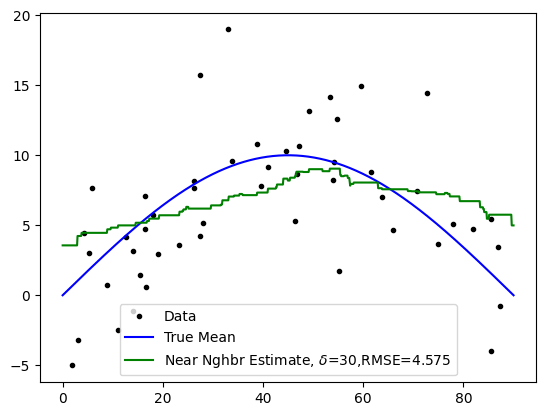

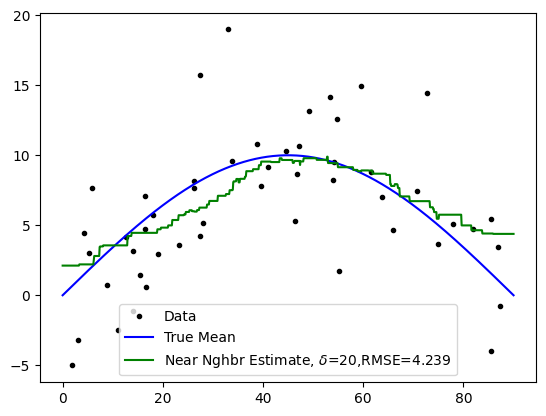

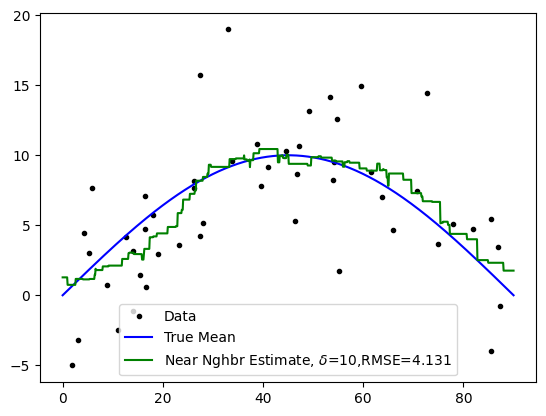

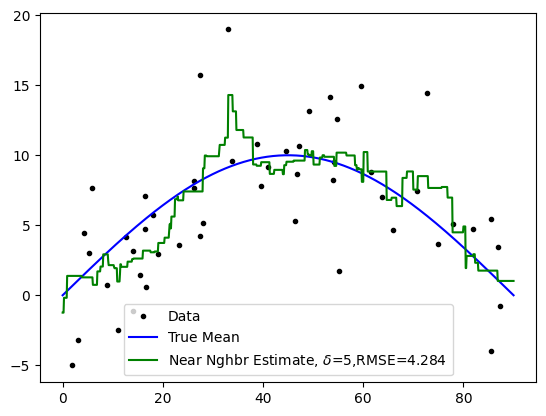

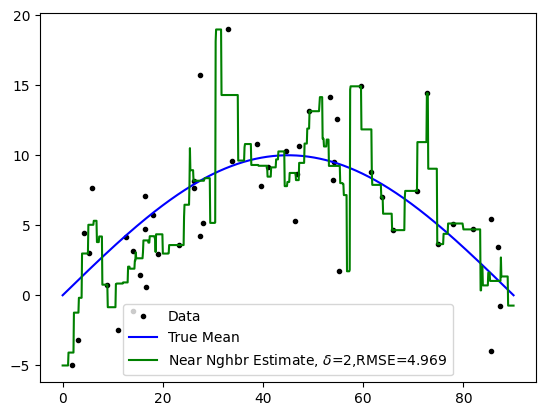

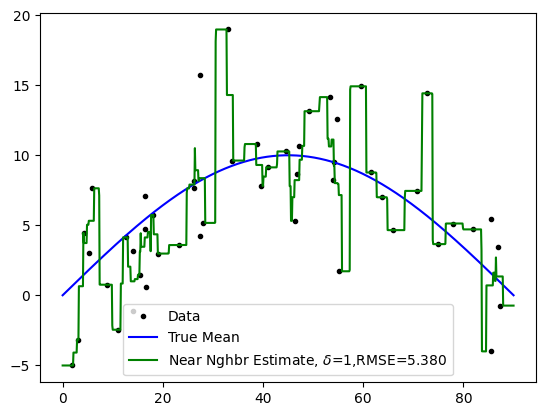

In [8]:
def wt_avg_est(x_vals,wt_func,dataX,dataY):
   #Strategy: Compute the weight for each (x_vals,dataX) pair by array brodcasting
   #.         Then sum over the dataX to compute the numerator and denominator
   wts = wt_func(x_vals[...,np.newaxis],dataX) #broadcast wt_func array to dataX size in last axis
   return np.sum( dataY*wts, axis=-1)/np.sum(wts,axis=-1)

def is_close_wt_func(x_1,x_2,window):
  return  1.0*(np.abs(x_1 - x_2)<window) + 0.00001*np.exp(-50*np.abs(x_1 - x_2))
  #Note: The exponential term makes the weighted averaging revert to Nearest Neighbour if there are no points

my_delta_list = [30,20,10,5,2,1]
for delta in my_delta_list:
  plt.plot(X,Y,'k.',label='Data')
  plt.plot(x_axis,secret_mean_func(x_axis),'b-',label = 'True Mean')
  estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(is_close_wt_func,window=delta),dataX=X,dataY=Y)
  RMSE = np.sqrt(np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - estimates)**2 ))
  plt.plot(x_axis,estimates,'g-',label=f'Near Nghbr Estimate, $\delta$={delta},RMSE={RMSE:.3f}')
  plt.legend()
  plt.show()


## Another Example: Gaussian Weights
Another example is the Gaussian weight that depends on a distance paramter $\sigma > 0$:

$$ \text{Wt}(x,x^\prime) = {exp}\left( \frac{(x-x^\prime)^2}{\sigma^2} \right)$$

This averages over ''nearby'' points again, where points get exponentially less weighted the further they are. The ''charateristic'' distance is $\sigma$; points within $\sigma$ count a lot and points many multiples of $\sigma$ count very little. This is somewhat similar to the nearby neighbour with window size $\sigma$, but is always defined!



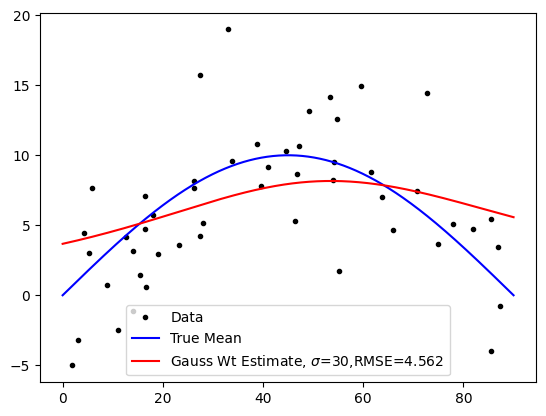

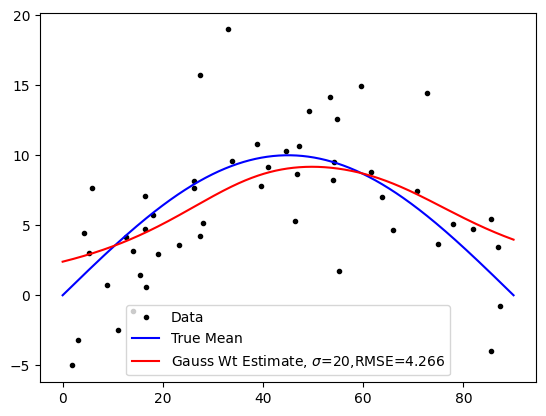

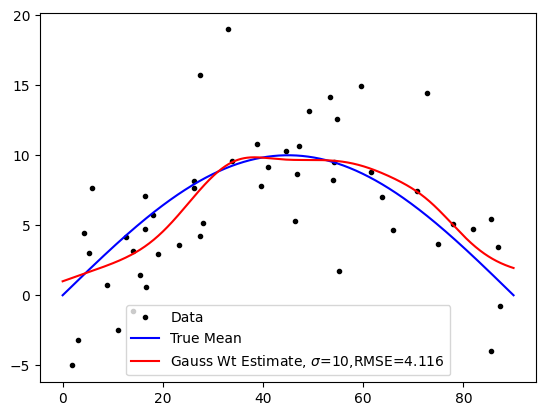

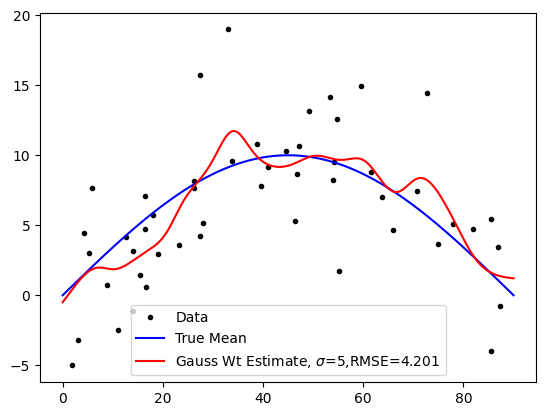

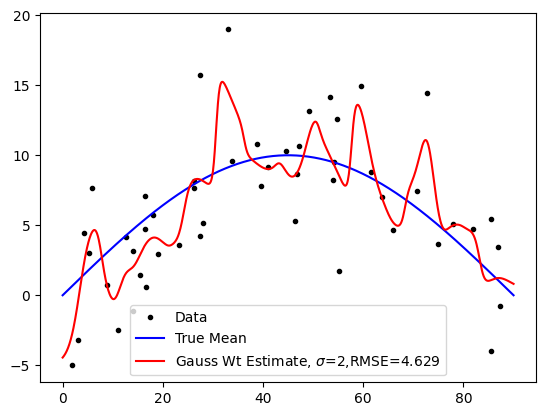

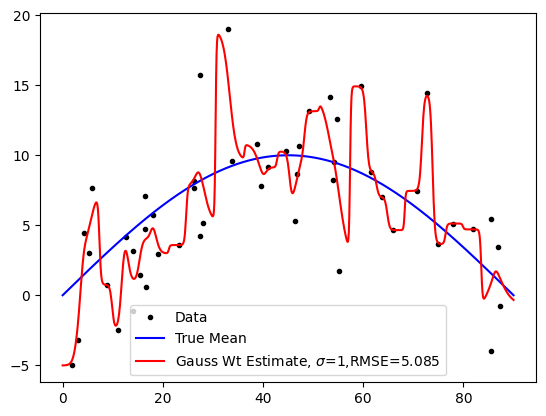

In [9]:
def gauss_wt(x_1,x_2,sigma):
  return np.exp(-(x_1-x_2)**2/sigma**2)

my_sigma_list = [30,20,10,5,2,1]
for i,my_sigma in enumerate(my_sigma_list):
  plt.plot(X,Y,'k.',label='Data')
  plt.plot(x_axis,secret_mean_func(x_axis),'b-',label = 'True Mean')
  estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X,dataY=Y)
  RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - estimates)**2 ))
  plt.plot(x_axis,estimates,'r-',label=f'Gauss Wt Estimate, $\sigma$={my_sigma},RMSE={RMSE:.3f}')
  plt.legend()
  plt.show()

# Comparison of RMSE for Gaussian and NN weights

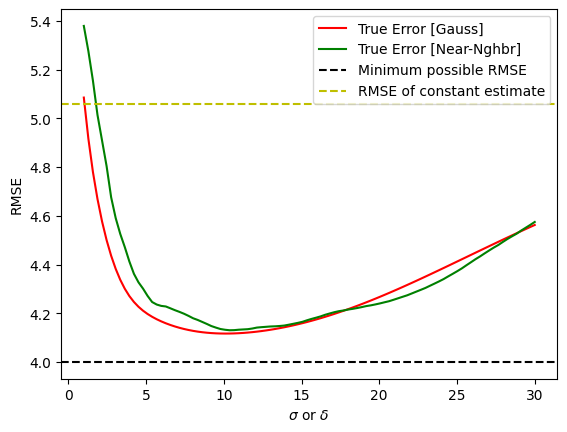

In [46]:
# Plot of RMSE vs various Sigma values

def plot_RMSE_vs_Val(min_val,max_val,show_const=True):

  #arrays to store the values and answers
  my_sigma_array = np.linspace(min_val,max_val,100)
  Gauss_RMSE_array = np.zeros_like(my_sigma_array)
  NN_RMSE_array = np.zeros_like(my_sigma_array)

  for i,my_sigma in enumerate(list(my_sigma_array)):
    Gauss_estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X,dataY=Y)
    Gauss_RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - Gauss_estimates)**2 ))
    Gauss_RMSE_array[i] = Gauss_RMSE

    NN_estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(is_close_wt_func,window=my_sigma),dataX=X,dataY=Y)
    NN_RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - NN_estimates)**2 ))
    NN_RMSE_array[i] = NN_RMSE


  plt.xlabel("$\sigma$ or $\delta$")
  plt.ylabel("RMSE")
  plt.plot(my_sigma_array,Gauss_RMSE_array,'r',label='True Error [Gauss]')
  plt.plot(my_sigma_array,NN_RMSE_array,'g',label='True Error [Near-Nghbr]')


  minimum_RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + 0 ))
  plt.axhline(y=minimum_RMSE, color='k', linestyle='--', label='Minimum possible RMSE')

  const_estimate = np.mean(Y)
  const_estimate_RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - const_estimate)**2 ))
  if show_const==True:
    plt.axhline(y=const_estimate_RMSE, color='y', linestyle='--', label='RMSE of constant estimate')


  plt.legend()

plot_RMSE_vs_Val(1,30)

# How to choose $\sigma$ or $\delta$ in practice?!?! Using a test set

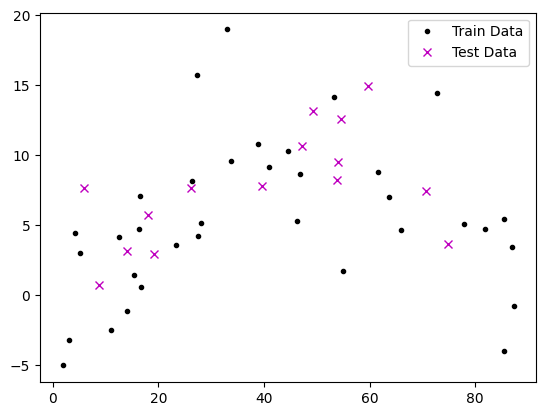

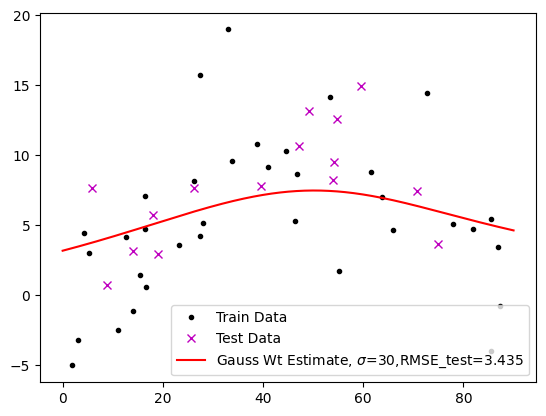

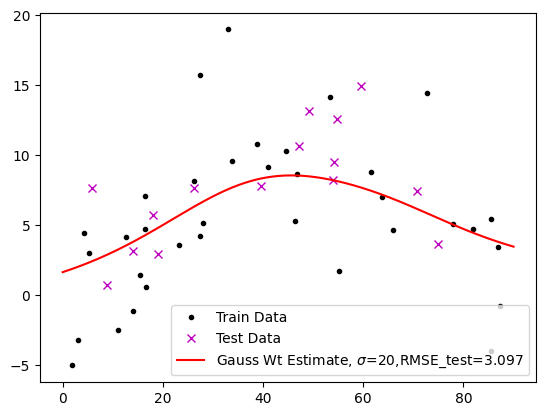

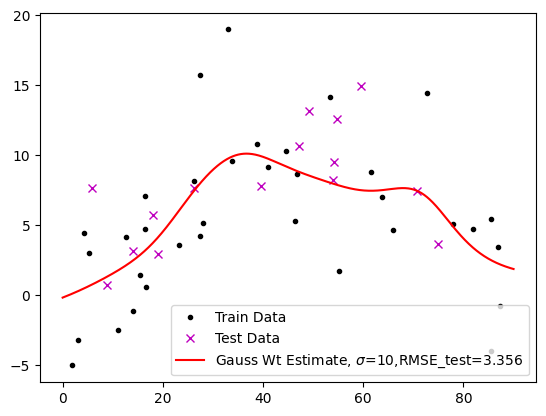

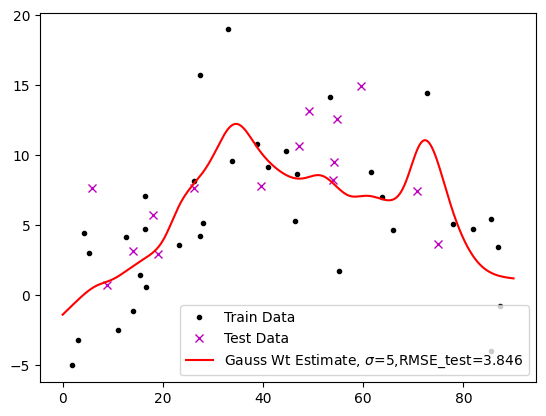

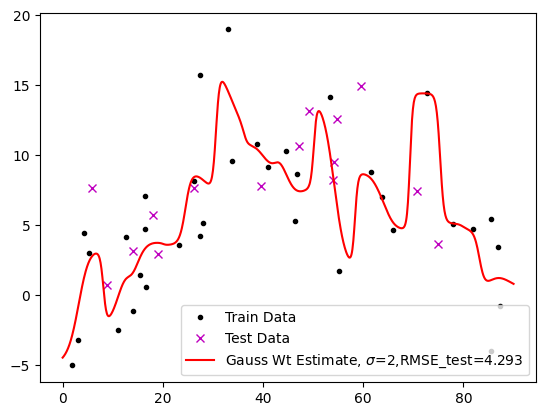

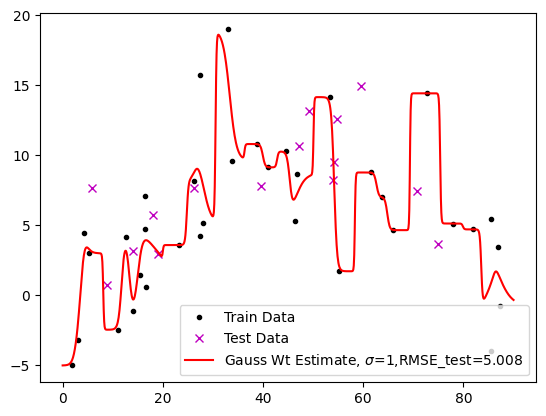

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

plt.plot(X_train,Y_train,'k.',label='Train Data')
plt.plot(X_test,Y_test,'mx',label='Test Data')


# Plot the true mean
x_axis = np.linspace(x_min,x_max,1000)
#plt.plot(x_axis,secret_mean_func(x_axis),'b-',label = 'True Mean')
plt.legend()
plt.show()


my_sigma_list = [30,20,10,5,2,1]
for i,my_sigma in enumerate(my_sigma_list):
  plt.plot(X_train,Y_train,'k.',label='Train Data')
  plt.plot(X_test,Y_test,'mx',label='Test Data')

  x_axis_estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X_train,dataY=Y_train)
  X_test_estimates = wt_avg_est(x_vals=X_test,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X_train,dataY=Y_train)

  ## Same idea but with the nearby neighbour avaeraging
  #x_axis_estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(is_close_wt_func,window=my_sigma),dataX=X_train,dataY=Y_train)
  #X_test_estimates = wt_avg_est(x_vals=X_test,wt_func=partial(is_close_wt_func,window=my_sigma),dataX=X_train,dataY=Y_train)


  RMSE_test =  np.sqrt(np.mean( (X_test_estimates - Y_test)**2 ))  #np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - estimates)**2 ))
  plt.plot(x_axis,x_axis_estimates,'r-',label=f'Gauss Wt Estimate, $\sigma$={my_sigma},RMSE_test={RMSE_test:.3f}')
  plt.legend()
  plt.show()


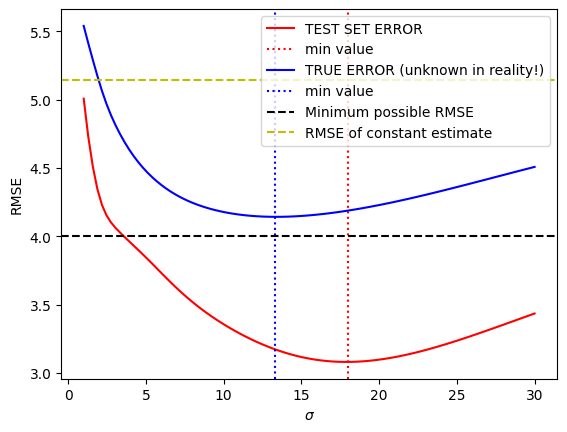

In [48]:
def plot_Test_RMSE_vs_Val(min_val,max_val,show_const=True):
  my_sigma_array = np.linspace(min_val,max_val,100)
  Gauss_RMSE_true_array = np.zeros_like(my_sigma_array)
  Gauss_RMSE_test_array = np.zeros_like(my_sigma_array)

  for i,my_sigma in enumerate(list(my_sigma_array)):
    X_test_estimates = wt_avg_est(x_vals=X_test,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X_train,dataY=Y_train)
    Gauss_RMSE_test = np.sqrt(np.mean( (X_test_estimates - Y_test)**2 ))
    Gauss_RMSE_test_array[i] = Gauss_RMSE_test

    Gauss_estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X_train,dataY=Y_train)
    Gauss_RMSE_true = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - Gauss_estimates)**2 ))
    Gauss_RMSE_true_array[i] = Gauss_RMSE_true



  plt.xlabel("$\sigma$")
  plt.ylabel("RMSE")
  plt.plot(my_sigma_array,Gauss_RMSE_test_array,'r',label='TEST SET ERROR')
  plt.axvline(x=my_sigma_array[np.argmin(Gauss_RMSE_test_array)],color='r',linestyle=':',label="min value")
  plt.plot(my_sigma_array,Gauss_RMSE_true_array,'b',label='TRUE ERROR (unknown in reality!)')
  plt.axvline(x=my_sigma_array[np.argmin(Gauss_RMSE_true_array)],color='b',linestyle=':',label="min value")


  minimum_RMSE = np.sqrt( np.mean( secret_sd_func(X_test)**2 + 0 ))
  plt.axhline(y=minimum_RMSE, color='k', linestyle='--', label='Minimum possible RMSE')

  const_estimate = np.mean(Y_train)
  const_estimate_RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - const_estimate)**2 ))
  if show_const==True:
    plt.axhline(y=const_estimate_RMSE, color='y', linestyle='--', label='RMSE of constant estimate')


  plt.legend()

plot_Test_RMSE_vs_Val(1,30)

# Leave one out error - Rerun the model many times

In the leave one out error, we use only a single point as our test set and all but that pointa as a trianing set.

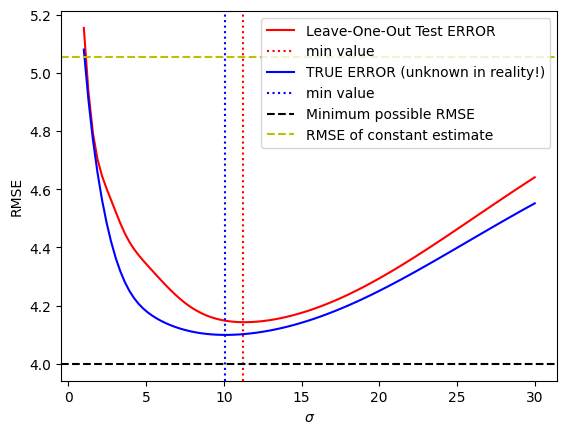

In [49]:
def plot_LOO_RMSE_vs_Val(min_val,max_val,show_const=True):
  my_sigma_array = np.linspace(min_val,max_val,100)
  Gauss_RMSE_true_array = np.zeros_like(my_sigma_array)
  Gauss_RMSE_LOO_array = np.zeros_like(my_sigma_array)

  for i,my_sigma in enumerate(list(my_sigma_array)):
    LOO_sq_err = np.zeros(N)
    for j in range(N):
      X_train = np.delete(X,j)
      Y_train = np.delete(Y,j)
      X_test = X[j]
      Y_test = Y[j]
      X_test_estimate = wt_avg_est(x_vals=X_test,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X_train,dataY=Y_train)
      LOO_sq_err[j] = (X_test_estimate - Y_test)**2

    Gauss_RMSE_LOO_array[i] =np.sqrt(np.mean(LOO_sq_err))

    Gauss_estimates = wt_avg_est(x_vals=x_axis,wt_func=partial(gauss_wt,sigma=my_sigma),dataX=X_train,dataY=Y_train)
    Gauss_RMSE_true = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - Gauss_estimates)**2 ))
    Gauss_RMSE_true_array[i] = Gauss_RMSE_true



  plt.xlabel("$\sigma$")
  plt.ylabel("RMSE")
  plt.plot(my_sigma_array,Gauss_RMSE_LOO_array,'r',label='Leave-One-Out Test ERROR')
  plt.axvline(x=my_sigma_array[np.argmin(Gauss_RMSE_LOO_array)],color='r',linestyle=':',label="min value")
  plt.plot(my_sigma_array,Gauss_RMSE_true_array,'b',label='TRUE ERROR (unknown in reality!)')
  plt.axvline(x=my_sigma_array[np.argmin(Gauss_RMSE_true_array)],color='b',linestyle=':',label="min value")



  minimum_RMSE = np.sqrt( np.mean( secret_sd_func(X_test)**2 + 0 ))
  plt.axhline(y=minimum_RMSE, color='k', linestyle='--', label='Minimum possible RMSE')

  const_estimate = np.mean(Y_train)
  const_estimate_RMSE = np.sqrt( np.mean( secret_sd_func(x_axis)**2 + (secret_mean_func(x_axis) - const_estimate)**2 ))
  if show_const==True:
    plt.axhline(y=const_estimate_RMSE, color='y', linestyle='--', label='RMSE of constant estimate')


  plt.legend()

plot_LOO_RMSE_vs_Val(1,30)